In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
train_data_path = 'data/train.csv'
prepared_data_path = 'data/train_prep.csv'
target = 'Price'

In [44]:
df = pd.read_csv(train_data_path, header=0)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


## Разведочный анализ

### Изучение целевой переменной

In [45]:
plt.style.use('fivethirtyeight')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Видим много пропусков в LifeSquare и в HealthCare, несколько категориальных призаков

In [47]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [48]:
target_mean = round(df[target].mean(), 2)
target_median = round(df[target].median(), 2)

target_mean, target_median

(214138.86, 192269.64)

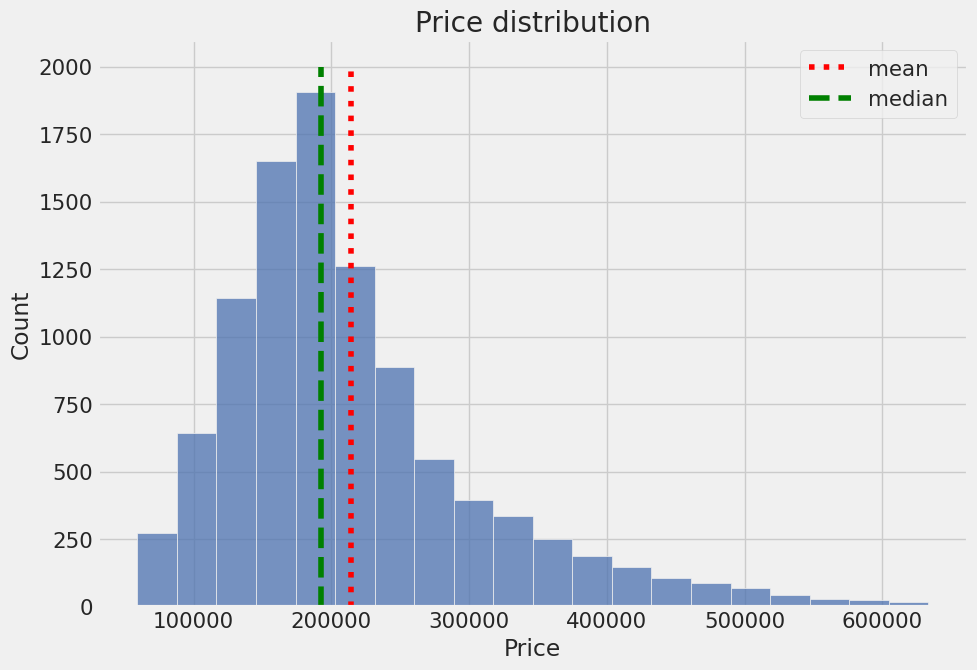

In [49]:
plt.figure(figsize=(10, 7))

y = np.linspace(0, 2000, 10)
sns.histplot(df['Price'], bins=20)


plt.plot([target_mean] * 10, y, label='mean', color='red', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', color='green', linestyle='--', linewidth=4)


plt.xlabel('Price')
plt.ylabel('Count')

plt.title('Price distribution')
plt.legend()

plt.show()

Данные распределены равномерно, выбросов не видно
- Медианная цена - 192269$, 
- Средняя цена дома в датасете - 214138$

### Распределения признаков

Посмотрим на heatmap

In [50]:
df_num_features = df.select_dtypes(include=['int64', 'float64'])

<AxesSubplot:>

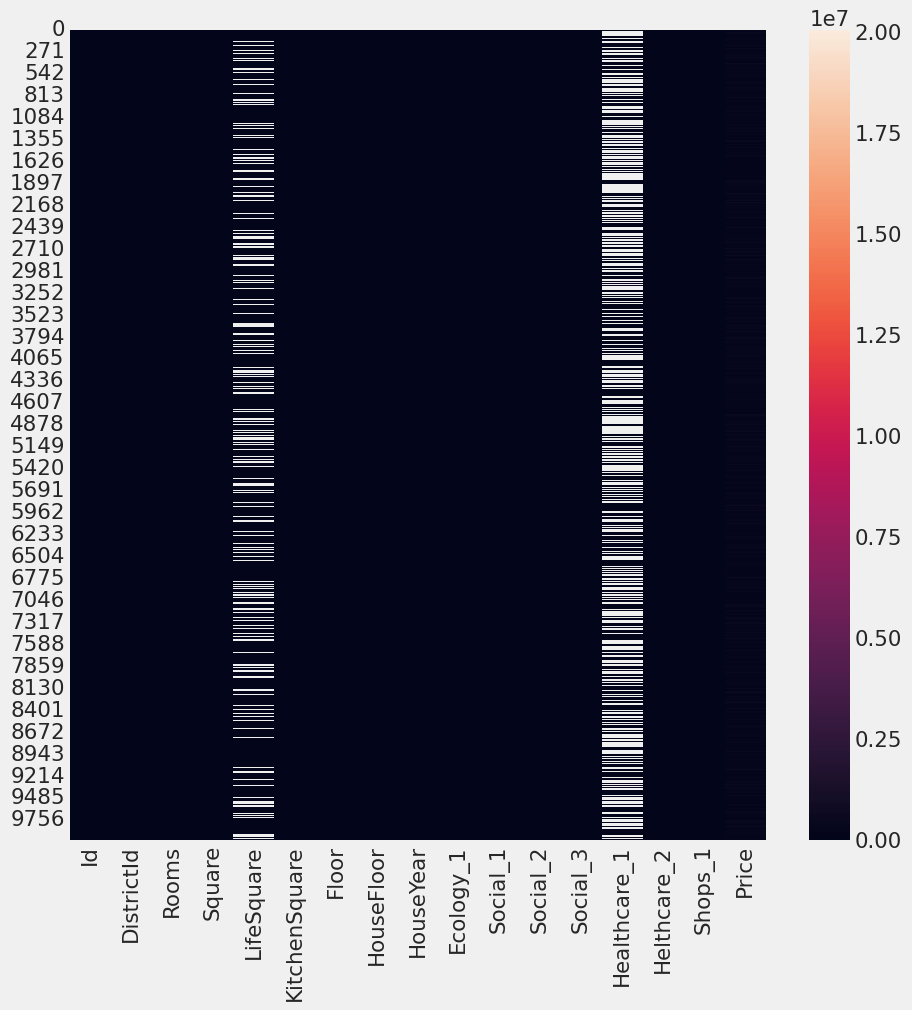

In [51]:
plt.figure(figsize=(10, 10))

sns.heatmap(df_num_features)

Посмотрим на выбросы 

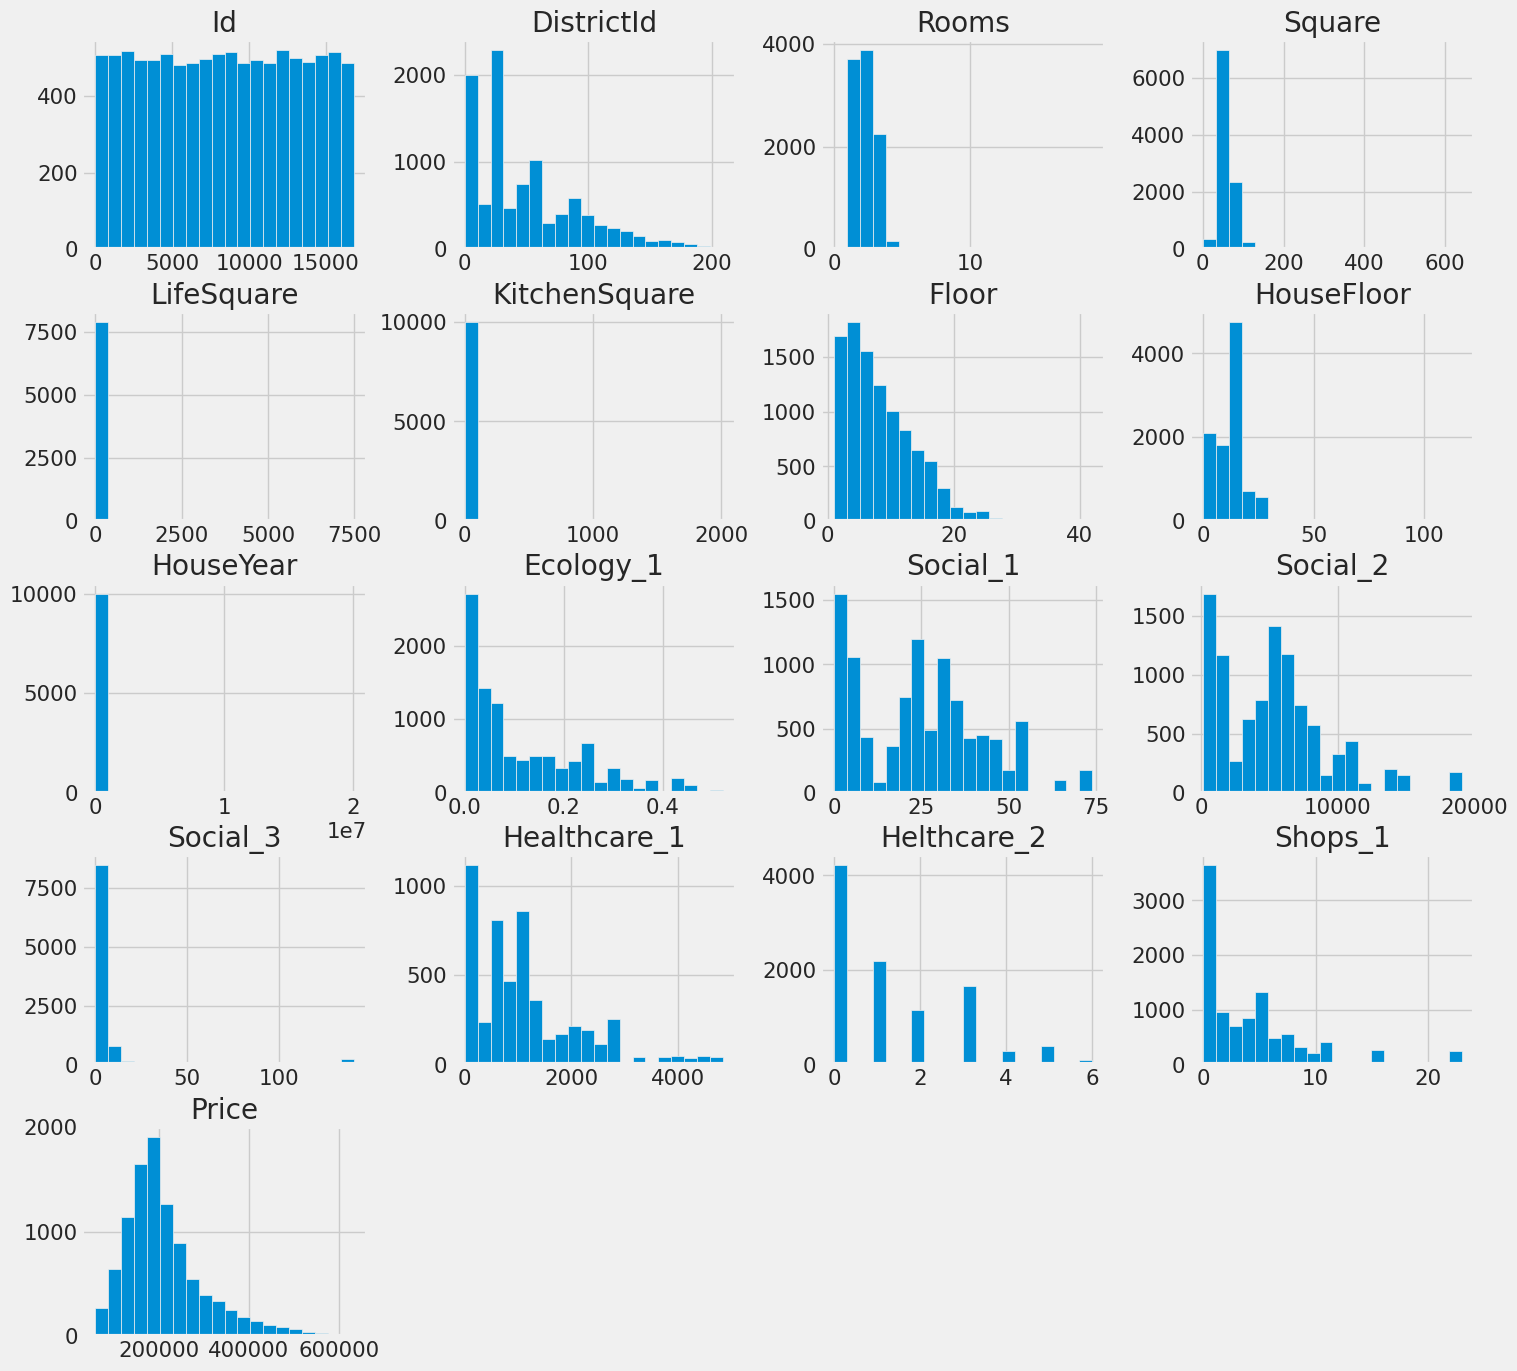

In [52]:
df_num_features.hist(bins=20, figsize=(16, 16))
plt.show()

Видим, что в признаках Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear скорее всего присутствуют выбросы

Посмотрим на них детальнее

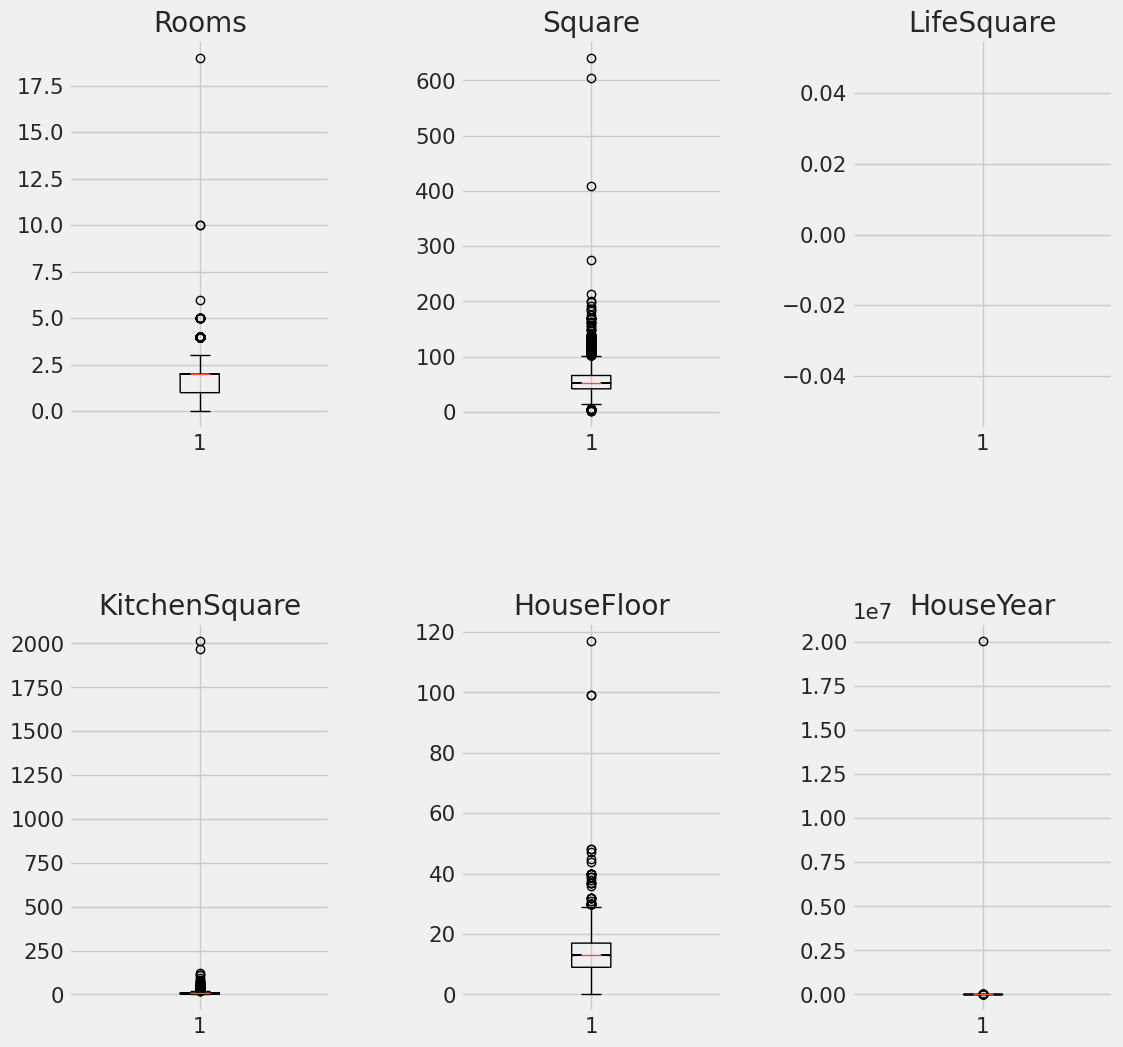

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.boxplot(df['Rooms'], ['Rooms'])
ax1.set_title('Rooms')

ax2.boxplot(df['Square'], ['Square'])
ax2.set_title('Square')

ax3.boxplot(df['LifeSquare'], ['LifeSquare'])
ax3.set_title('LifeSquare')

ax4.boxplot(df['KitchenSquare'], ['KitchenSquare'])
ax4.set_title('KitchenSquare')

ax5.boxplot(df['HouseFloor'], ['HouseFloor'])
ax5.set_title('HouseFloor')

ax6.boxplot(df['HouseYear'], ['HouseYear'])
ax6.set_title('HouseYear')

fig.set_size_inches(12, 12)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

Почистим их от выбросов, затем заполним LifeSquare

In [54]:
df.loc[df['Rooms']>=10, 'Rooms'] = df['Rooms'].median()
df.loc[df['Rooms'] == 0.0, 'Rooms'] = df['Rooms'].median()
df['Rooms'].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

In [55]:
df.loc[df['Square']>=200, 'Square'] = df['Square'].median()

In [56]:
df.loc[df['KitchenSquare']>=50, 'KitchenSquare'] = df['KitchenSquare'].median()
df.loc[df['KitchenSquare']==0, 'KitchenSquare']  = df['KitchenSquare'].median()

In [57]:
# Удалим из выборки квартиры, этаж которых больше 50
df = df[df['HouseFloor'] <= 50]
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

In [58]:
df = df[df['HouseYear'] <= 2022]
df.loc[df['HouseYear'] < 1500, 'HouseYear'] = df['HouseYear'].median()

In [59]:
# Заполним пустые поля LifeSquare значением Square - KitchenSquare
df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df[df['LifeSquare'].isna()]['Square'] - df[df['LifeSquare'].isna()]['KitchenSquare']
df.loc[df['LifeSquare']>=100, 'LifeSquare'] = df.loc[df['LifeSquare']>=100, 'Square'] - df.loc[df['LifeSquare']>=100, 'KitchenSquare']
df.loc[df['LifeSquare']==0, 'LifeSquare'] = df.loc[df['LifeSquare']==0, 'Square'] - df.loc[df['LifeSquare']==0, 'KitchenSquare']

In [60]:
df.loc[df['LifeSquare']>=100, 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['LifeSquare']==0.0, 'LifeSquare'] = df['LifeSquare'].median()

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9995 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9995 non-null   int64  
 1   DistrictId     9995 non-null   int64  
 2   Rooms          9995 non-null   float64
 3   Square         9995 non-null   float64
 4   LifeSquare     9995 non-null   float64
 5   KitchenSquare  9995 non-null   float64
 6   Floor          9995 non-null   int64  
 7   HouseFloor     9995 non-null   float64
 8   HouseYear      9995 non-null   int64  
 9   Ecology_1      9995 non-null   float64
 10  Ecology_2      9995 non-null   object 
 11  Ecology_3      9995 non-null   object 
 12  Social_1       9995 non-null   int64  
 13  Social_2       9995 non-null   int64  
 14  Social_3       9995 non-null   int64  
 15  Healthcare_1   5198 non-null   float64
 16  Helthcare_2    9995 non-null   int64  
 17  Shops_1        9995 non-null   int64  
 18  Shops_2 

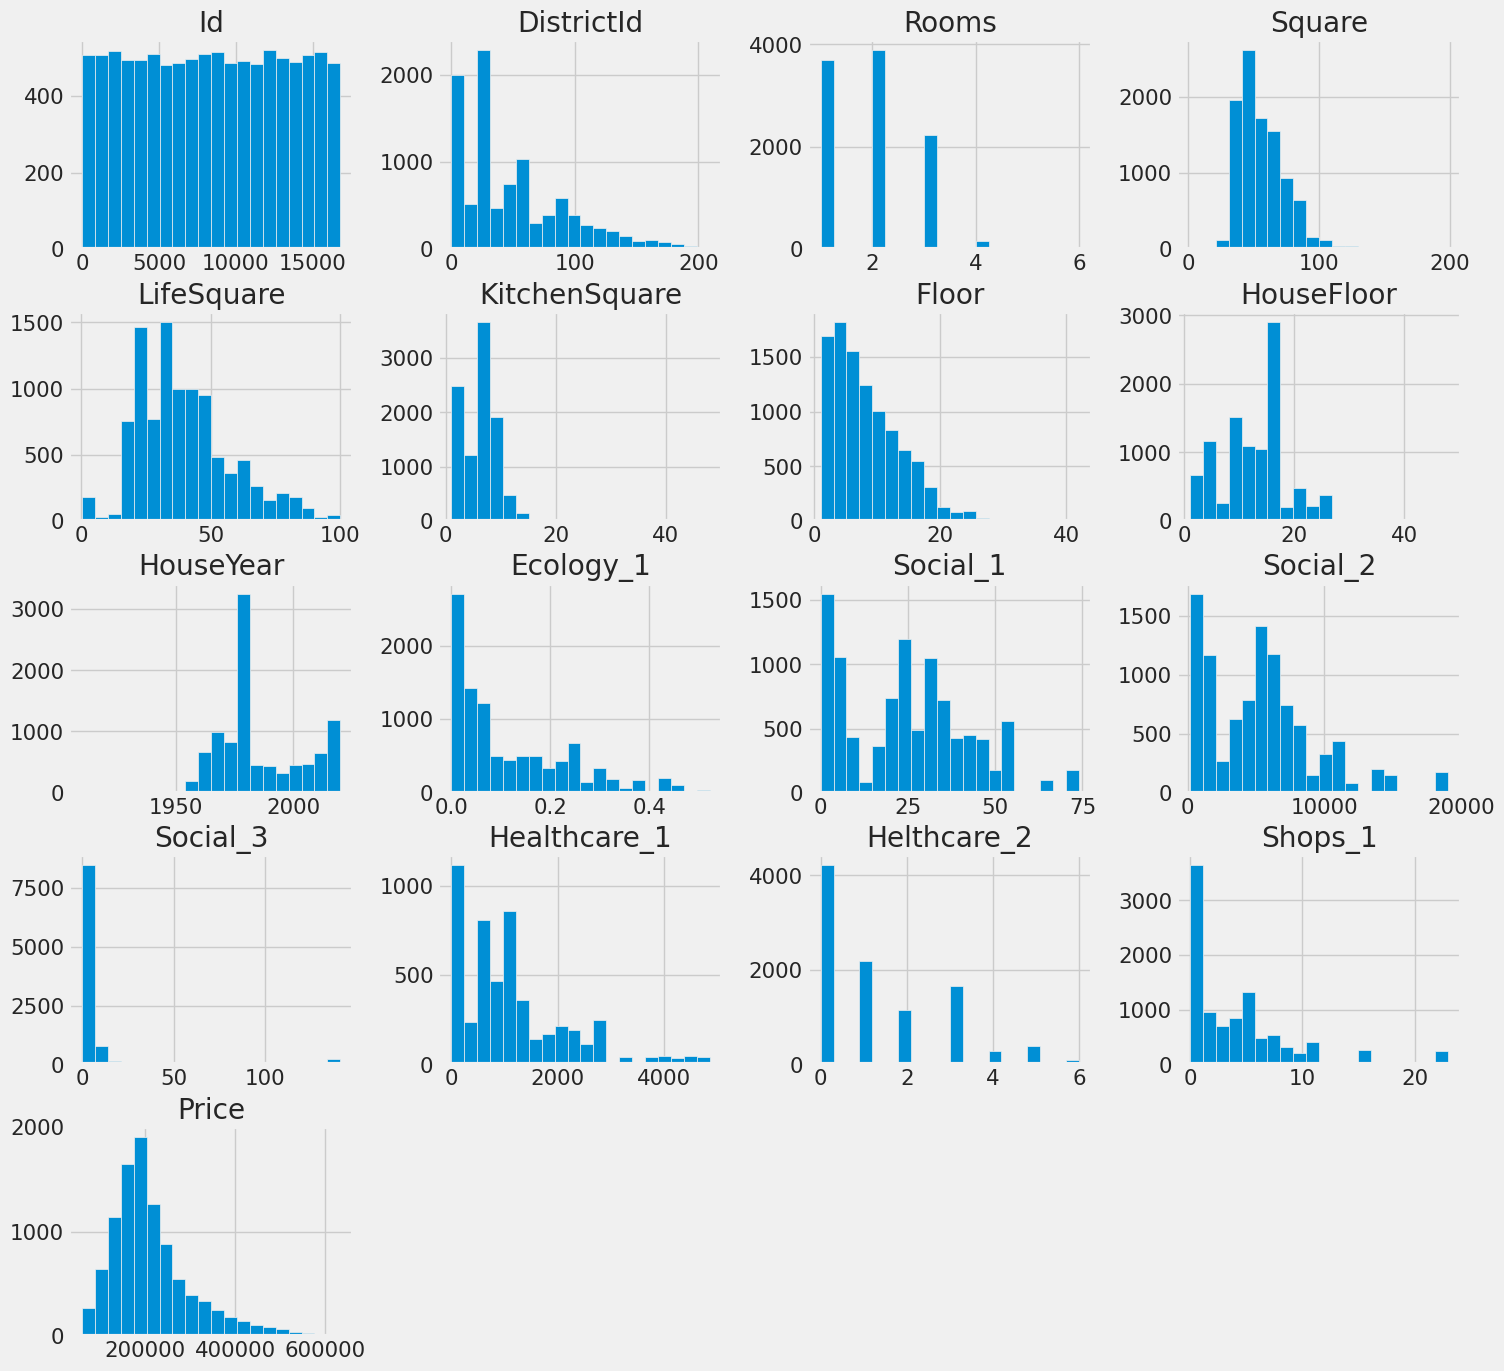

In [62]:
df_num_features = df.select_dtypes(include=['int64', 'float64'])
df_num_features.hist(bins=20, figsize=(16, 16))
plt.show()

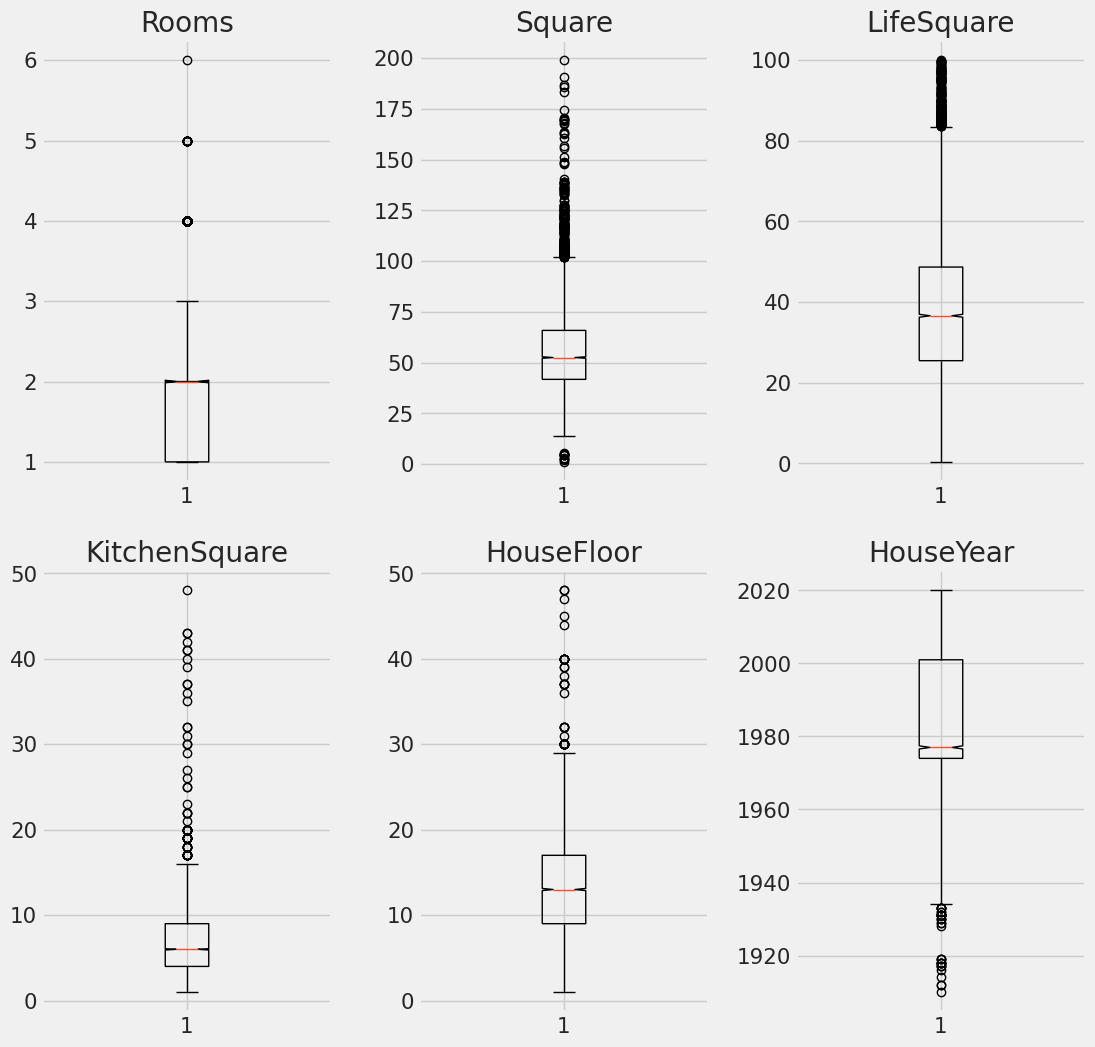

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.boxplot(df['Rooms'], ['Rooms'])
ax1.set_title('Rooms')

ax2.boxplot(df['Square'], ['Square'])
ax2.set_title('Square')

ax3.boxplot(df['LifeSquare'], ['LifeSquare'])
ax3.set_title('LifeSquare')

ax4.boxplot(df['KitchenSquare'], ['KitchenSquare'])
ax4.set_title('KitchenSquare')

ax5.boxplot(df['HouseFloor'], ['HouseFloor'])
ax5.set_title('HouseFloor')

ax6.boxplot(df['HouseYear'], ['HouseYear'])
ax6.set_title('HouseYear')

fig.set_size_inches(12, 12)
plt.subplots_adjust(hspace=0.2, wspace=0.3)

В графе Healthcare_1 слишком много пропусков, посмотрим, какая корреляция у этого признака с ценой

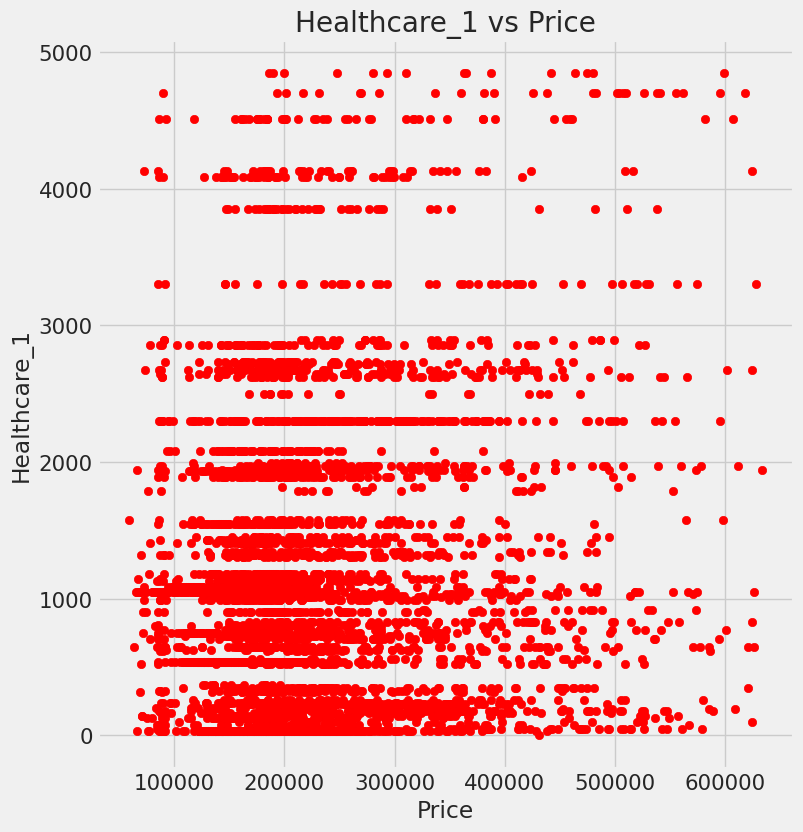

In [64]:
plt.figure(figsize=(8, 9))
plt.scatter(df[target], df['Healthcare_1'], color='red')
plt.xlabel('Price')
plt.ylabel('Healthcare_1')
plt.title('Healthcare_1 vs Price')
plt.show()

прямой зависимости у признака нет, поэтому удалим его

In [65]:
df = df.drop(['Healthcare_1'], axis=1)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644


id и DistrictId на цену не влияют, их тоже удалим

In [66]:
df = df.drop(['Id', 'DistrictId'], axis=1)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644


**Матрица корреляций**

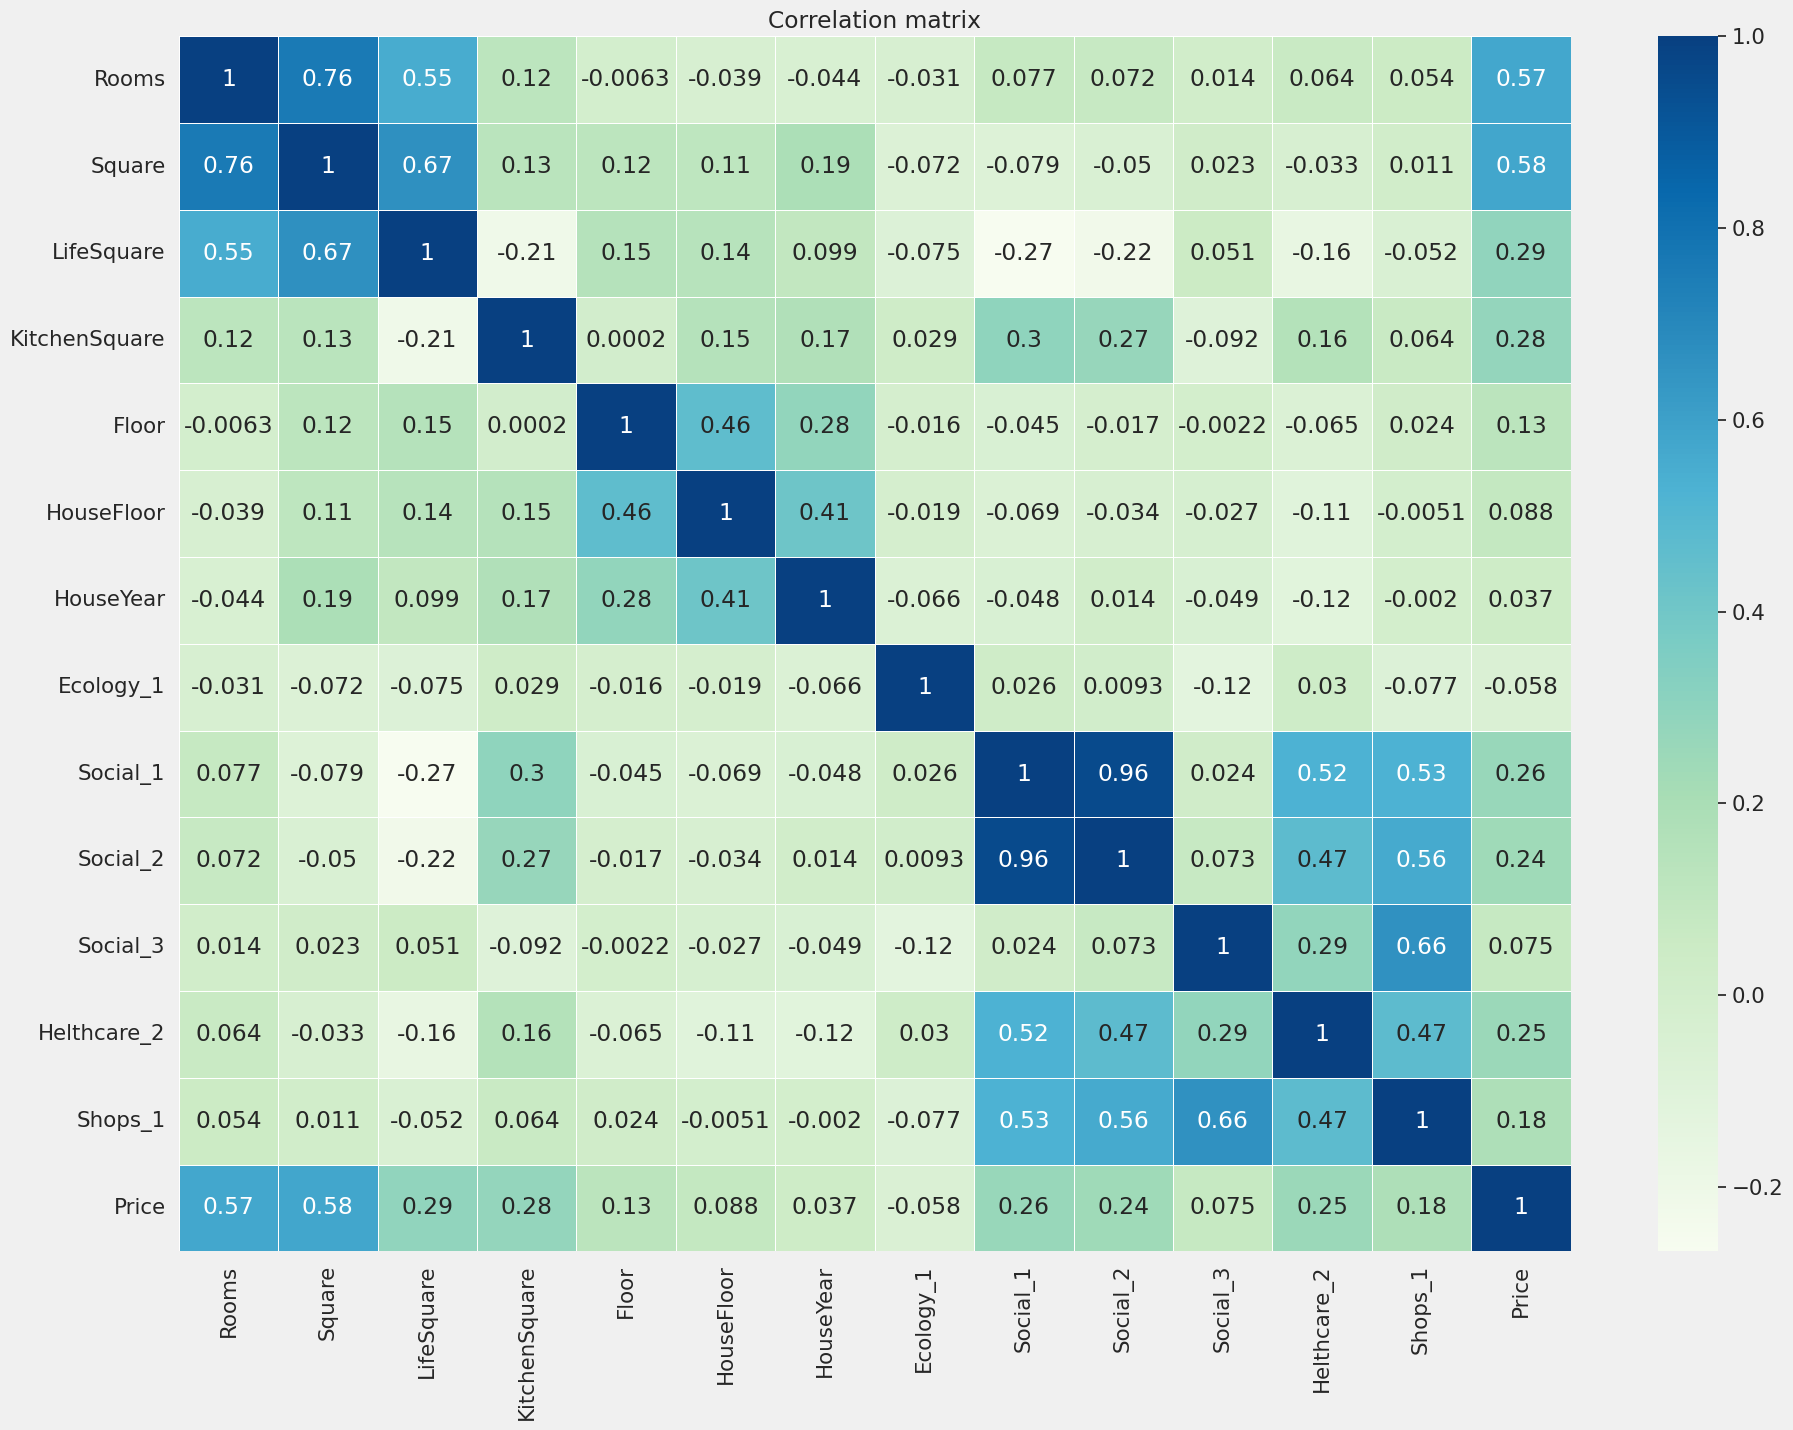

In [67]:
plt.figure(figsize=(20, 15))

sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, linewidth=.5, cmap='GnBu') 

plt.title('Correlation matrix')
plt.show()

### Приведение типов данных и добавление признаков

In [68]:
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644


Судя по распределениям, Ecology_2, Ecolody_3, Helthcare_2, Shops_2 являются категориальными признаками. Посмотрим на категории:

In [69]:
df['Ecology_2'].value_counts()

B    9898
A      97
Name: Ecology_2, dtype: int64

In [70]:
df['Ecology_3'].value_counts()

B    9720
A     275
Name: Ecology_3, dtype: int64

In [71]:
df['Helthcare_2'].value_counts()

0    4213
1    2183
3    1668
2    1158
5     387
4     287
6      99
Name: Helthcare_2, dtype: int64

In [72]:
df['Shops_2'].value_counts()

B    9170
A     825
Name: Shops_2, dtype: int64

Пусть в тех признаках, где 2 категории, А будет 1, а В - 0

In [73]:
df.loc[df['Ecology_2']=='A', 'Ecology_2'] = 1
df.loc[df['Ecology_2']=='B', 'Ecology_2'] = 0
df['Ecology_2'].value_counts()

0    9898
1      97
Name: Ecology_2, dtype: int64

In [74]:
df.loc[df['Ecology_3']=='A', 'Ecology_3'] = 1
df.loc[df['Ecology_3']=='B', 'Ecology_3'] = 0

df.loc[df['Shops_2']=='A', 'Shops_2'] = 1
df.loc[df['Shops_2']=='B', 'Shops_2'] = 0
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531644


из Helthcare_2 6 dummie признаков

In [75]:
df['Ecology_2'] = df['Ecology_2'].astype(np.int64)
df['Ecology_3'] = df['Ecology_3'].astype(np.int64)
df['Shops_2'] = df['Shops_2'].astype(np.int64)


df['Helthcare_2'] = df['Helthcare_2'].astype('category')

Сохраним подготовленные данные в файл

In [76]:
df.to_csv(prepared_data_path, index=False, encoding='utf-8')

Для простоты обработки тестовых данных, оформим все наши действия в функцию 

In [77]:
def data_prep(df):
    df.loc[df['Rooms']>=10, 'Rooms'] = df['Rooms'].median()
    df.loc[df['Rooms'] == 0.0, 'Rooms'] = df['Rooms'].median()
    df.loc[df['Square']>=200, 'Square'] = df['Square'].median()
    df.loc[df['KitchenSquare']>=50, 'KitchenSquare'] = df['KitchenSquare'].median()
    df.loc[df['KitchenSquare']==0, 'KitchenSquare']  = df['KitchenSquare'].median()
    df = df[df['HouseFloor'] <= 50]
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
    df = df[df['HouseYear'] <= 2022]
    df.loc[df['HouseYear'] < 1500, 'HouseYear'] = df['HouseYear'].median()
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df[df['LifeSquare'].isna()]['Square'] - df[df['LifeSquare'].isna()]['KitchenSquare']
    df.loc[df['LifeSquare']>=100, 'LifeSquare'] = df.loc[df['LifeSquare']>=100, 'Square'] - df.loc[df['LifeSquare']>=100, 'KitchenSquare']
    df.loc[df['LifeSquare']==0, 'LifeSquare'] = df.loc[df['LifeSquare']==0, 'Square'] - df.loc[df['LifeSquare']==0, 'KitchenSquare']
    df.loc[df['LifeSquare']>=100, 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['LifeSquare']==0.0, 'LifeSquare'] = df['LifeSquare'].median()
    df = df.drop(['Healthcare_1'], axis=1)
    df = df.drop(['Id', 'DistrictId'], axis=1)
    df.loc[df['Ecology_2']=='A', 'Ecology_2'] = 1
    df.loc[df['Ecology_2']=='B', 'Ecology_2'] = 0
    df.loc[df['Ecology_3']=='A', 'Ecology_3'] = 1
    df.loc[df['Ecology_3']=='B', 'Ecology_3'] = 0
    df.loc[df['Shops_2']=='A', 'Shops_2'] = 1
    df.loc[df['Shops_2']=='B', 'Shops_2'] = 0
    df['Ecology_2'] = df['Ecology_2'].astype(np.int64)
    df['Ecology_3'] = df['Ecology_3'].astype(np.int64)
    df['Shops_2'] = df['Shops_2'].astype(np.int64)
    df['Helthcare_2'] = df['Helthcare_2'].astype('category')
    return df